In [1]:
import jax.numpy as jnp
import jax
jax.config.update("jax_enable_x64", True)

import numpy as np
import scipy
import matplotlib.pyplot as plt

import sys, os

In [2]:
sys.path.insert(0, "/home/storage/hans/jax_reco_new")
from lib.cgamma import c_gamma_prob, c_gamma_sf, c_multi_gamma_prob, c_multi_gamma_sf
from lib.plotting import adjust_plot_1d
from lib.network import get_network_eval_fn
from lib.geo import get_xyz_from_zenith_azimuth
from lib.trafos import transform_network_outputs, transform_network_inputs

In [3]:
eval_network = get_network_eval_fn(bpath='/home/storage/hans/jax_reco_new/data/network')

In [4]:
dist = 17.66502672
z = -361.78880666
rho = -0.19604577
zenith = 2.28442419 
azimuth = 3.9264083

x = jnp.array([dist, rho, z, zenith, azimuth])
x_prime = transform_network_inputs(x)
y = eval_network(x_prime)
logits, gamma_a, gamma_b = transform_network_outputs(y)
mix_probs = jax.nn.softmax(logits)

In [5]:
xvals = np.linspace(-20, 100, 1000)
xvals_r = xvals.reshape(1000, 1)

/home/storage/hans/jax_reco_new/lib/plotting.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


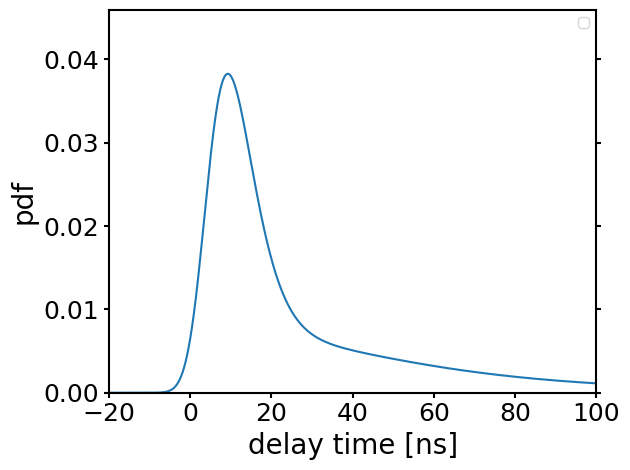

In [6]:
probs = c_multi_gamma_prob(xvals_r, mix_probs, gamma_a, gamma_b, 3.0, 0.1)

fig, ax = plt.subplots()
plt.plot(xvals, probs)
plot_args = {'xlim':[-20, 100],
                     'ylim':[0.0, 1.2 * np.amax(probs)],
                     'xlabel':'delay time [ns]',
                     'ylabel':'pdf'}
    
adjust_plot_1d(fig, ax, plot_args=plot_args)
plt.tight_layout()
plt.show()

In [7]:
c_multi_gamma_sf_v1d = jax.vmap(c_multi_gamma_sf, (0, None, None, None, None), 0)

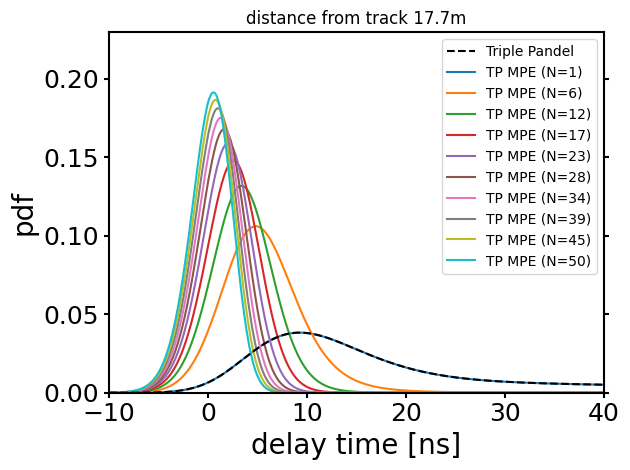

In [8]:
sfs = c_multi_gamma_sf_v1d(xvals, mix_probs, gamma_a, gamma_b, 3.0)

fig, ax = plt.subplots()
plt.plot(xvals, probs,linestyle='dashed', color='black', zorder=100, label='Triple Pandel')

y_max = np.amax(probs)
n_photons = jnp.array(np.linspace(1, 50, 10))
for n_p in n_photons:
    ys = n_p * probs * sfs**(n_p-1)
    plt.plot(xvals, ys, label=f'TP MPE (N={n_p:.0f})')
    y_max = np.amax([y_max, np.amax(ys)])
plot_args = {'xlim':[-10, 40],
                     'ylim':[0.0, 1.2*y_max],
                     'xlabel':'delay time [ns]',
                     'ylabel':'pdf'}
    
adjust_plot_1d(fig, ax, plot_args=plot_args)
plt.title(f"distance from track {dist:.1f}m")
plt.tight_layout()
plt.show()

In [9]:
# test gradient

c_gamma_sf_grad = jax.grad(c_gamma_sf, argnums=(1,2))

In [10]:
for i in range(3):
    print(c_gamma_sf(20.0, gamma_a[i], gamma_b[i], 3.0))

0.7623180106049505
0.09525796063820743
0.9591556998455995


In [11]:
for i in range(3):
    print(c_gamma_sf_grad(20.0, gamma_a[i], gamma_b[i], 3.0))

(Array(0.27666223, dtype=float64), Array(-7.9028602, dtype=float64))
(Array(0.07790528, dtype=float64), Array(-1.08385096, dtype=float64))
(Array(0.14686839, dtype=float64), Array(-19.10726901, dtype=float64))


In [12]:
def log_c_gamma_mpe(x, a, b, sigma, n_photons):
    prob = c_gamma_prob(x, a, b, sigma=sigma, delta=0.1)
    sf = c_gamma_sf(x, a, b, sigma=3.0)
    #ys = n_p * probs * sfs**(n_p-1)
    return jnp.log(n_photons) + jnp.log(prob) + (n_photons-1) * jnp.log(sf)

log_c_gamma_mpe_grad = jax.grad(log_c_gamma_mpe, argnums=(1,2))

In [13]:
x = 6.37511258
n_p = 2

for i in range(3):
    print("fn:", log_c_gamma_mpe(x, gamma_a[i], gamma_b[i], 3.0, n_p))

for i in range(3):
    print("grad:", log_c_gamma_mpe_grad(x, gamma_a[i], gamma_b[i], 3.0, n_p))

fn: -3.942683160177937
fn: -2.4078177716478533
fn: -5.515958195186433
grad: (Array(-1.52142054, dtype=float64), Array(36.2637241, dtype=float64))
grad: (Array(-0.16277818, dtype=float64), Array(2.25273904, dtype=float64))
grad: (Array(-3.82217863, dtype=float64), Array(465.18145105, dtype=float64))


In [14]:
print(mix_probs)

[0.37396457 0.50085446 0.12518097]


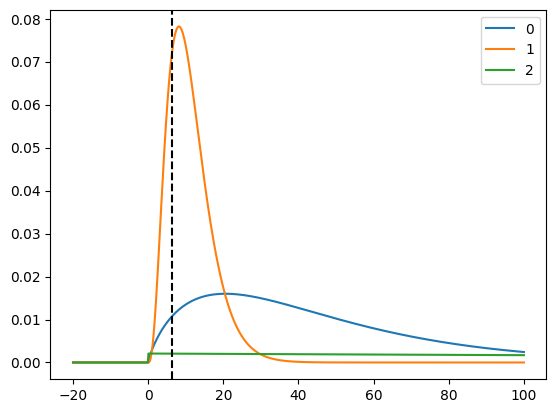

In [15]:
from scipy.stats import gamma
xvals = np.linspace(-20, 100, 1000)

fig, ax = plt.subplots()
for i in range(3):
    probs = gamma.pdf(xvals, gamma_a[i], scale=1/gamma_b[i])
    plt.plot(xvals, probs, label=f"{i}")

plt.axvline(x, color='black', linestyle='dashed')
plt.legend()
plt.show()

In [16]:
print(gamma_a)

[1.82426548 3.73101993 1.00109866]


In [17]:
print(mix_probs)

[0.37396457 0.50085446 0.12518097]


In [18]:
def finite_difference_grad(x, gamma_a, gamma_b, sigma, n_p):
    eps = 1.e-4
    
    fval1 = log_c_gamma_mpe(x, gamma_a+eps, gamma_b, sigma, n_p)
    fval2 = log_c_gamma_mpe(x, gamma_a-eps, gamma_b, sigma, n_p)
    grad1 = (fval1 - fval2)/(2*eps)

    fval1 = log_c_gamma_mpe(x, gamma_a, gamma_b+eps, sigma, n_p)
    fval2 = log_c_gamma_mpe(x, gamma_a, gamma_b-eps, sigma, n_p)
    grad2 = (fval1 - fval2)/(2*eps)
    
    return jnp.array([grad1, grad2])

In [19]:
for i in range(3):
    print("fn:", finite_difference_grad(x, gamma_a[i], gamma_b[i], 3.0, n_p))

fn: [-1.52142054 36.26381915]
fn: [-0.16277818  2.2527394 ]
fn: [ -3.82217862 465.54511576]
